In [16]:
import mechwolf as mw

# create components
a = mw.Vessel(name="a", description="nothing")
b = mw.Vessel(name="b", description="nothing")
c = mw.Vessel(name="c", description="nothing")

pump = mw.DummyPump(name="Dummy pump")


test = mw.ErraticDummySensor(name="test")
# test2 = mw.DummySensor(name="test2")
# test3 = mw.DummySensor(name="test3")
# test4 = mw.DummySensor(name="test4")

tube = mw.Tube("1 foot", "1/16 in", "2/16 in", "PVC")

# create apparatus
A = mw.Apparatus()
A.add([a, b, c], pump, tube)
A.add(pump, test, tube)

P = mw.Protocol(A)
P.add(pump, rate="5 mL/min", start="0 seconds", stop="15 secs")
P.add(pump, rate="10 mL/min",start="15 seconds", stop="30 secs")
P.add(test, rate="15 Hz", start="0 secs", stop="60 secs")

In [25]:
#Returns immediately with an Experiment object that will update as it gets new data
E = P.execute(confirm=True)

In [23]:
import rrcf
from statistics import stdev, mean

read_rate = 15

# Set tree parameters
num_trees = 50
shingle_size = 3
tree_size = 256
codisp_threshold = 20
stdev_threshold = 4
min_data = 100

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [24]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(map(lambda x: x.data, E.data["test"]), shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees
    if avg_codisp[index] > codisp_threshold:
        print("Anomaly detected!: ", avg_codisp[index], codisp_threshold)
    if index > min_data and mean(avg_codisp.values()) + stdev(avg_codisp.values()) * stdev_threshold < avg_codisp[index]:
        print("Anomaly detected via stdev!:", index)

Anomaly detected via stdev!: 196
Anomaly detected via stdev!: 221
Anomaly detected via stdev!: 222


Text(0.5, 1.0, 'Sine wave with injected anomaly (red) and anomaly score (blue)')

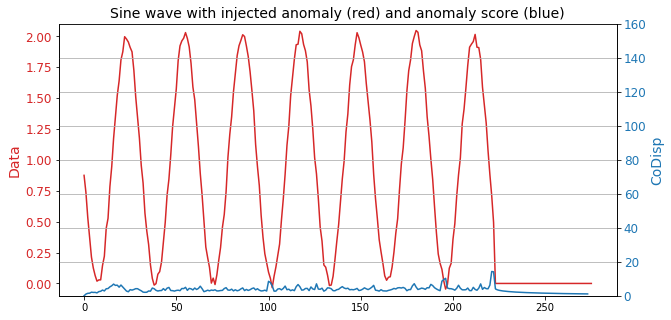

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(list(map(lambda x: x.data, E.data["test"])), color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(-.1,2.1)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)

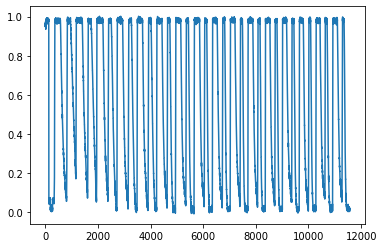

In [22]:
# with open("/Users/BenjaminLee/Library/Containers/com.apple.mail/Data/Library/Mail Downloads/90EE37BB-BD2A-4FD2-8A3A-FAD9E8A73382/2019_08_02_16_03_06_38e53be7.data.jsonl") as f:
#     x = f.readlines()
# import json
# x = map(lambda z: json.loads(z), x)
# x = list(map(lambda z: z["data"], list(x)))
# from matplotlib import pyplot as plt
# plt.plot(x)